# Sentiment Analysis of Reviews
### Michael Benno
### 12/10/25

### Introduction:
Question: What is the overall review of the restuarants in Baltimore, Maryland at dinner time?

Summary of solution: 

In [19]:
import requests
import yelpkeys  # file where client_id and api_key is defined with user's private app information
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from nltk.corpus import stopwords
from operator import itemgetter
from wordcloud import WordCloud

In [3]:
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

In [4]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'Baltimore, MD'
SEARCH_LIMIT = 20


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

In [5]:
response = search(API_KEY,DEFAULT_TERM, DEFAULT_LOCATION)

Querying https://api.yelp.com/v3/businesses/search ...


In [6]:
response

{'businesses': [{'id': 'PPhWrn5tZwBKBYesnMuSGQ',
   'alias': 'costiera-baltimore',
   'name': 'Costiera',
   'image_url': 'https://s3-media0.fl.yelpcdn.com/bphoto/A3tR5LVf-1t-36vd3WyRew/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/costiera-baltimore?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 86,
   'categories': [{'alias': 'mediterranean', 'title': 'Mediterranean'},
    {'alias': 'italian', 'title': 'Italian'},
    {'alias': 'tapasmallplates', 'title': 'Tapas/Small Plates'}],
   'rating': 4.7,
   'coordinates': {'latitude': 39.285602, 'longitude': -76.598904},
   'transactions': [],
   'location': {'address1': '415 S Central Ave',
    'address2': '',
    'address3': None,
    'city': 'Baltimore',
    'zip_code': '21202',
    'country': 'US',
    'state': 'MD',
    'display_address': ['415 S Central Ave', 'Baltimore, MD 21202']},
   'phone': '+14434384363',

In [7]:
neutral = 0
positive = 0
negative = 0
for business in response['businesses']:
    #print(response)
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        print(' - ' + review['text'])
        # Perform sentiment analysis on the review using TextBlob
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            positive += 1
            print('    Sentiment: Positive')
        elif sentiment < 0:
            negative += 1
            print('    Sentiment: Negative')
        else:
            neutral += 1
            print('    Sentiment: Neutral')
        print('\n================\n\n\n')

Business Name: CLOCK Restoration
Rating: 4.5
Review Count: 192
Reviews: 
Querying https://api.yelp.com/v3/businesses/Kh1XJP54vra02w7vS5rRhg/reviews ...
 - ​This place felt like a proper speakeasy from the moment we walked in. The fact that it's on the sixth floor and has that exclusive, "passcodes and...
    Sentiment: Neutral




 - I really wanted to like this spot, but the food missed the mark. The bartender/server was awesome. He made a really well-balanced seasonal cocktail and...
    Sentiment: Positive




 - Totally cool place, great atmosphere, lots of tasty cocktails and awesome server (Corey)...but....the place was out of a significant amount of items on the...
    Sentiment: Positive




Business Name: Costiera
Rating: 4.7
Review Count: 86
Reviews: 
Querying https://api.yelp.com/v3/businesses/PPhWrn5tZwBKBYesnMuSGQ/reviews ...
 - We had the best time. The food was great and the staff was really nice! We'll definitely come back soon.
    Sentiment: Positive




 - It's 3 day

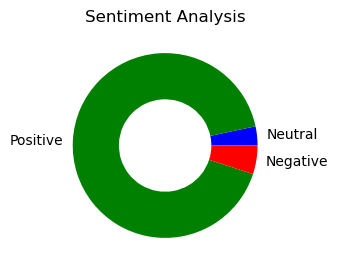

In [8]:
# Define data
labels = ['Neutral', 'Positive', 'Negative']
values = [neutral/60, positive/60, negative/60]

# Create donut chart
fig, ax = plt.subplots(figsize=(3, 3))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['blue', 'green', 'red'])
ax.set_title('Sentiment Analysis')

plt.show()

In [9]:
neutral = 0
positive = 0
negative = 0
for business in response['businesses']:
    #print(response)
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        print(' - ' + review['text'])
        # Perform sentiment analysis on the review using TextBlob
        blob = TextBlob(review['text'],analyzer=NaiveBayesAnalyzer())
        sentiment = blob.sentiment.classification
        if 'pos' in sentiment:
            positive += 1
            print('    Sentiment: Positive')
        elif 'neg' in sentiment:
            negative += 1
            print('    Sentiment: Negative')
        else:
            neutral += 1
            print('    Sentiment: Neutral')
        print('\n================\n\n\n')

Business Name: CLOCK Restoration
Rating: 4.5
Review Count: 192
Reviews: 
Querying https://api.yelp.com/v3/businesses/Kh1XJP54vra02w7vS5rRhg/reviews ...
 - ​This place felt like a proper speakeasy from the moment we walked in. The fact that it's on the sixth floor and has that exclusive, "passcodes and...
    Sentiment: Positive




 - I really wanted to like this spot, but the food missed the mark. The bartender/server was awesome. He made a really well-balanced seasonal cocktail and...
    Sentiment: Negative




 - Totally cool place, great atmosphere, lots of tasty cocktails and awesome server (Corey)...but....the place was out of a significant amount of items on the...
    Sentiment: Positive




Business Name: Costiera
Rating: 4.7
Review Count: 86
Reviews: 
Querying https://api.yelp.com/v3/businesses/PPhWrn5tZwBKBYesnMuSGQ/reviews ...
 - We had the best time. The food was great and the staff was really nice! We'll definitely come back soon.
    Sentiment: Positive




 - It's 3 da

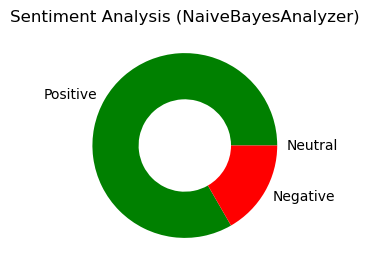

In [10]:
# Define data
labels = ['Neutral', 'Positive', 'Negative']
values = [neutral/60, positive/60, negative/60]

# Create donut chart
fig, ax = plt.subplots(figsize=(3, 3))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['blue', 'green', 'red'])
ax.set_title('Sentiment Analysis (NaiveBayesAnalyzer)')

plt.show()

In [9]:
sentences = ""
for business in response['businesses']:
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        sentences += str(review['text'])
        sentences += '\n'
print(sentences)

Querying https://api.yelp.com/v3/businesses/PPhWrn5tZwBKBYesnMuSGQ/reviews ...
Querying https://api.yelp.com/v3/businesses/Kh1XJP54vra02w7vS5rRhg/reviews ...
Querying https://api.yelp.com/v3/businesses/annMRFs28xF_O1f1YsMzjQ/reviews ...
Querying https://api.yelp.com/v3/businesses/EyzwOeUWwoKGeZcOcVUW0A/reviews ...
Querying https://api.yelp.com/v3/businesses/ieS_5zqxDHcWMCm8BKUYbg/reviews ...
Querying https://api.yelp.com/v3/businesses/GQiSt5uZUEptA0HqmszkSQ/reviews ...
Querying https://api.yelp.com/v3/businesses/fai58PHxZKmdxlN2VMF0EQ/reviews ...
Querying https://api.yelp.com/v3/businesses/UdfSQpXyrP5Dl23RJlVfyA/reviews ...
Querying https://api.yelp.com/v3/businesses/5CM8nuqd0od68GqQ-UGicQ/reviews ...
Querying https://api.yelp.com/v3/businesses/lakHUpHkRM3OcSBMJmB07Q/reviews ...
Querying https://api.yelp.com/v3/businesses/ORxOJG-ghaXzPy77RfRKNA/reviews ...
Querying https://api.yelp.com/v3/businesses/7A46TFNpfZLTpo0HWc3dZA/reviews ...
Querying https://api.yelp.com/v3/businesses/KDlBNN9X

In [12]:
stop_words = stopwords.words('english')

In [14]:
items = TextBlob(sentences).word_counts.items()

In [15]:
items = [item for item in items if item[0] not in stop_words]
items

[('best', 1),
 ('time', 7),
 ('food', 21),
 ('great', 12),
 ('staff', 2),
 ('really', 9),
 ('nice', 5),
 ('definitely', 3),
 ('come', 2),
 ('back', 2),
 ('soon', 1),
 ('3', 1),
 ('days', 1),
 ('later', 1),
 ('caught', 1),
 ('day', 2),
 ('dreaming', 1),
 ('meal', 4),
 ('multiple', 1),
 ('times', 2),
 ('recommend', 4),
 ('beautiful', 3),
 ('tapas', 1),
 ('joint', 1),
 ('enough', 2),
 ('start', 2),
 ('made', 7),
 ('late', 2),
 ('night', 4),
 ('reservation', 2),
 ('costiera', 1),
 ('steps', 1),
 ('away', 1),
 ('hotel', 3),
 ("n't", 5),
 ('busy', 3),
 ('weekday', 2),
 ('\u200bthis', 1),
 ('place', 17),
 ('felt', 1),
 ('like', 5),
 ('proper', 1),
 ('speakeasy', 1),
 ('moment', 1),
 ('walked', 1),
 ('fact', 2),
 ('sixth', 1),
 ('floor', 2),
 ('exclusive', 1),
 ('passcodes', 1),
 ('wanted', 2),
 ('spot', 5),
 ('missed', 1),
 ('mark', 1),
 ('bartender/server', 1),
 ('awesome', 3),
 ('well-balanced', 1),
 ('seasonal', 1),
 ('cocktail', 2),
 ('totally', 1),
 ('cool', 2),
 ('atmosphere', 3),
 ('lo

In [17]:
sorted_items = sorted(items, key=itemgetter(1), reverse=True)

In [18]:
top_20 = sorted_items[0:21]
top_20

[('food', 21),
 ('place', 17),
 ('great', 12),
 ('really', 9),
 ('baltimore', 9),
 ('delicious', 9),
 ('service', 8),
 ('time', 7),
 ('made', 7),
 ('first', 7),
 ('good', 7),
 ('absolutely', 6),
 ('amazing', 6),
 ('restaurant', 6),
 ('dinner', 6),
 ('nice', 5),
 ("n't", 5),
 ('like', 5),
 ('spot', 5),
 ('one', 5),
 ('super', 5)]

In [20]:
wordcloud = WordCloud(colormap='prism',background_color='white', max_words=20)

In [28]:
df = pd.DataFrame(top_20, columns=['Word', 'Count'])

In [30]:
wordcloud = wordcloud.generate(str(df['Word']))

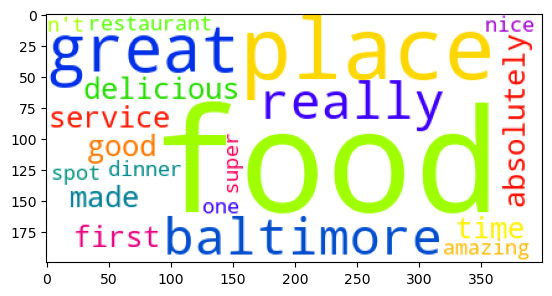

In [31]:
plt.imshow(wordcloud)